<a href="https://colab.research.google.com/github/tofighi/MachineLearning/blob/master/sample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!wget -q https://sinamedialab.com/repository/documents/alfred/cars2.mp4 -O obstacle.mp4
!wget -q https://sinamedialab.com/repository/documents/alfred/cars2_depth.mp4 -O obstacle_depth.mp4

# Resize the video and make it gray

In [23]:
import cv2
import numpy as np
import argparse
import imutils
import time
import cv2
import os

 
cap = cv2.VideoCapture('/content/obstacle.mp4')
cap2 = cv2.VideoCapture('/content/obstacle_depth.mp4')
 
fourcc = cv2.VideoWriter_fourcc(*'XVID')
out = cv2.VideoWriter('obstacle_1280x720.mp4',fourcc, 24, (1280,640))
out2 = cv2.VideoWriter('obstacle_depth_1280x720.mp4',fourcc, 24, (1280,640))
 
while True:
    ret, frame = cap.read()
    if ret == True:
        b = cv2.resize(frame,(1280,640),fx=0,fy=0, interpolation = cv2.INTER_CUBIC)
        out.write(b)
    else:
        break

while True:
    ret, frame = cap2.read()
    if ret == True:
        b = cv2.resize(frame,(1280,640),fx=0,fy=0, interpolation = cv2.INTER_CUBIC)
        b = cv2.cvtColor(b, cv2.COLOR_BGR2GRAY)
        gray = cv2.cvtColor(b, cv2.COLOR_GRAY2RGB)  
        out2.write(gray)
    else:
        break

cap.release()
out.release()
cap2.release()
out2.release()
cv2.destroyAllWindows()

# Choose Right side of video (ignore ground) and take the average

Set up a threshold for the average to make sure we have an obstacle

# Take the average of boudning boxes

This [link](https://stackoverflow.com/questions/35586206/how-to-get-an-average-pixel-value-of-a-gray-scale-image-in-python-using-pil-nump/35586366) will show you the code

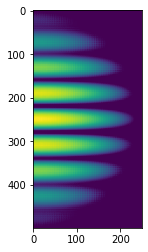

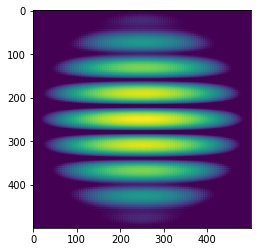

60.262488
60.259472


In [31]:
from skimage import io
import numpy as np

image = io.imread('http://i.stack.imgur.com/Y8UeF.jpg')

height, width = image.shape[:2]

ROI = image[0:int(height), int(width/2):width]

from matplotlib import pyplot as plt
plt.imshow(ROI)
plt.show()

plt.imshow(image)
plt.show()


print(np.mean(image))
print(np.mean(ROI))

# Download object detection models

In [25]:
!mkdir yolo-coco 
!wget -q https://sinamedialab.com/repository/documents/alfred/yolo-coco/coco.names -O /content/yolo-coco/coco.names
!wget -q https://sinamedialab.com/repository/documents/alfred/yolo-coco/yolov3.weights -O /content/yolo-coco/yolov3.weights
!wget -q https://sinamedialab.com/repository/documents/alfred/yolo-coco/yolov3.cfg -O /content/yolo-coco/yolov3.cfg

# Object Detection

In [38]:
args = {}
args["yolo"] = "yolo-coco"
args["confidence"] = 0.2
args["threshold"] = 0.2
args["input"] = "obstacle_1280x720.mp4"
args["input_depth"] = "obstacle_depth_1280x720.mp4"
args["output"] = "obstacle_out.mp4"
args["obstacles"] = ["car"]

# load the COCO class labels our YOLO model was trained on
labelsPath = os.path.sep.join([args["yolo"], "coco.names"])
LABELS = open(labelsPath).read().strip().split("\n")

# initialize a list of colors to represent each possible class label
np.random.seed(42)
COLORS = np.random.randint(0, 255, size=(len(LABELS), 3),
	dtype="uint8")

# derive the paths to the YOLO weights and model configuration
weightsPath = os.path.sep.join([args["yolo"], "yolov3.weights"])
configPath = os.path.sep.join([args["yolo"], "yolov3.cfg"])

# load our YOLO object detector trained on COCO dataset (80 classes)
# and determine only the *output* layer names that we need from YOLO
print("[INFO] loading YOLO from disk...")
net = cv2.dnn.readNetFromDarknet(configPath, weightsPath)
ln = net.getLayerNames()
ln = [ln[i[0] - 1] for i in net.getUnconnectedOutLayers()]

# initialize the video stream, pointer to output video file, and
# frame dimensions
vs = cv2.VideoCapture(args["input"])
vs_depth = cv2.VideoCapture(args["input_depth"])


writer = None
(W, H) = (None, None)

# try to determine the total number of frames in the video file
try:
	prop = cv2.cv.CV_CAP_PROP_FRAME_COUNT if imutils.is_cv2() \
		else cv2.CAP_PROP_FRAME_COUNT
	total = int(vs.get(prop))
	print("[INFO] {} total frames in video".format(total))

# an error occurred while trying to determine the total
# number of frames in the video file
except:
	print("[INFO] could not determine # of frames in video")
	print("[INFO] no approx. completion time can be provided")
	total = -1

# loop over frames from the video file stream
count = 0
while True:
	# read the next frame from the file
	(grabbed, frame) = vs.read()
	(grabbed_depth, frame_depth) = vs_depth.read()
	# if the frame was not grabbed, then we have reached the end
	# of the stream
	count = count+1
	if (count == 50):
		break
	if not grabbed:
		break
	c1 = 50
	r1 = 50
	#frame = frame[c1:c1+100,r1:r1+100]
	# if the frame dimensions are empty, grab them
	if W is None or H is None:
		(H, W) = frame.shape[:2]

	# construct a blob from the input frame and then perform a forward
	# pass of the YOLO object detector, giving us our bounding boxes
	# and associated probabilities
	blob = cv2.dnn.blobFromImage(frame, 1 / 255.0, (416, 416),
		swapRB=True, crop=False)
	net.setInput(blob)
	start = time.time()
	layerOutputs = net.forward(ln)
	end = time.time()

	# initialize our lists of detected bounding boxes, confidences,
	# and class IDs, respectively
	boxes = []
	confidences = []
	classIDs = []

	# loop over each of the layer outputs
	for output in layerOutputs:
		# loop over each of the detections
		for detection in output:
			# extract the class ID and confidence (i.e., probability)
			# of the current object detection
			scores = detection[5:]
			classID = np.argmax(scores)
			confidence = scores[classID]

			# filter out weak predictions by ensuring the detected
			# probability is greater than the minimum probability
			# if object is in list of obstacles
			if (confidence > args["confidence"] and LABELS[classID] in args["obstacles"] ):
				# scale the bounding box coordinates back relative to
				# the size of the image, keeping in mind that YOLO
				# actually returns the center (x, y)-coordinates of
				# the bounding box followed by the boxes' width and
				# height
				box = detection[0:4] * np.array([W, H, W, H])
				(centerX, centerY, width, height) = box.astype("int")

				# use the center (x, y)-coordinates to derive the top
				# and and left corner of the bounding box
				x = int(centerX - (width / 2))
				y = int(centerY - (height / 2))
				#ignore left
				if (x<0.5*W or x>0.9*W):
					break
				
				# update our list of bounding box coordinates,
				# confidences, and class IDs
				boxes.append([x, y, int(width), int(height)])
				confidences.append(float(confidence))
				classIDs.append(classID)

	# apply non-maxima suppression to suppress weak, overlapping
	# bounding boxes
	idxs = cv2.dnn.NMSBoxes(boxes, confidences, args["confidence"],
		args["threshold"])

	# ensure at least one detection exists
	if len(idxs) > 0:
		# loop over the indexes we are keeping
		for i in idxs.flatten():
			# extract the bounding box coordinates
			(x, y) = (boxes[i][0], boxes[i][1])
			(w, h) = (boxes[i][2], boxes[i][3])


			# draw a bounding box rectangle and label on the frame
			color = [int(c) for c in COLORS[classIDs[i]]]
			cv2.rectangle(frame_depth, (x, y), (x + w, y + h), color, 2)
			text = "{}: {:.4f}".format(LABELS[classIDs[i]],
				confidences[i])
			cv2.putText(frame_depth, text, (x, y - 5),
				cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)



	# check if the video writer is None
	if writer is None:
		# initialize our video writer
		fourcc = cv2.VideoWriter_fourcc(*"MJPG")
		writer = cv2.VideoWriter(args["output"], fourcc, 30,
			(frame_depth.shape[1], frame_depth.shape[0]), True)

		# some information on processing single frame
		if total > 0:
			elap = (end - start)
			print("[INFO] single frame took {:.4f} seconds".format(elap))
			print("[INFO] estimated total time to finish: {:.4f}".format(
				elap * total))

	# write the output frame to disk
	writer.write(frame_depth)

# release the file pointers
print("[INFO] cleaning up...")
writer.release()
vs.release()

[INFO] loading YOLO from disk...
[INFO] 376 total frames in video
[INFO] single frame took 1.9284 seconds
[INFO] estimated total time to finish: 725.0859
[INFO] cleaning up...
